<a href="https://colab.research.google.com/github/shaikadish/imdbProject/blob/main/model_training_and_testing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# The moment we have all been waiting for...

Time to train and test our model!

# Imports and setup

In [ ]:
# Mount to google drive
from google.colab import drive
drive.mount('/content/drive',force_remount=True)
%cd drive/MyDrive/path/to/your/directory

In [ ]:
# Install and import libraries
!pip install transformers

from transformers import BertTokenizer, AutoModel
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, random_split, DataLoader
import matplotlib.pyplot as plt
import time
import datetime
from matplotlib.lines import Line2D
import warnings
import numpy as np

In [ ]:
# Load the BERT tokenizer. The tokenizer used here is discussed later
print('Loading BERT tokenizer...')
tokenizer = BertTokenizer.from_pretrained('fabriceyhc/bert-base-uncased-imdb', do_lower_case=True)

In [ ]:
# Load in the model input data and targets
review_data=pd.read_csv('review_data_learning.csv')
reviews=review_data['0'].to_list()
ratings=review_data['1'].to_list()

In [ ]:
# A helper function used during training
def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

# Preprocessing and data preparation

We first must tokenize our text data appropriately for the BERT model we are using. Luckily, Hugging Face has us covered with its great tokenizer pipeline:

In [ ]:
# Lists containing BERT input data from the tokenizer
tokenized_reviews = []
attention_masks = []

# Loop through each review and tokeize
for review in reviews:

    # Encode the review using BERT tokenizer
    encoded_dict = tokenizer.encode_plus(
                        review,                      
                        truncation=True,
                        add_special_tokens = True, 
                        max_length = 512,          
                        pad_to_max_length = True,
                        return_attention_mask = True)
    
    # Append tokenized sentence   
    tokenized_reviews.append(encoded_dict['input_ids'])
    
    # Append the attention mask (padding locations within token set)
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors
tokenized_reviews = torch.tensor(tokenized_reviews)
attention_masks = torch.tensor(attention_masks)

# Convert targets list into tensor
labels = torch.tensor(ratings)

Now we must create our training, validation and testing datasets:

In [ ]:
# Generate a dataset using our model input data and targets 
dataset = TensorDataset(tokenized_reviews, attention_masks, labels)

# Calculate the size of the data subsets (70-15-15 split for training, validation and testing sets)
train_size = int(0.7 * len(dataset))+1
val_size = int(0.5*(len(dataset) - train_size))
test_size = int(0.5*(len(dataset) - train_size))

# Generate subsets of the data using the above split
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size,test_size])

And then create *PyTorch* dataloaders for training and testing:

In [ ]:
# We will use a batch size of 16, as recommended by the creators of BERT
batch_size = 16

# Create training dataloader 
train_dataloader = DataLoader(
            train_dataset, 
            shuffle=True,
            batch_size = batch_size 
        )

# Create validation dataloader
validation_dataloader = DataLoader(
            val_dataset, 
            batch_size = batch_size 
        )

# Create testing dataloader
test_dataloader = DataLoader(
            test_dataset, 
            batch_size = batch_size 
        )

# Model design and transfer learning

As mentioned, we are using BERT architecture for our model, due to it's excellent performance in sequence classification tasks. 

Because the popular IMDB dataset for sentiment analysis also makes use of IMDB review data, and because the model likely will makes use of similar features from the input data when classifying sentiment as when estimating a review score, it will be beneficial to perform transfer learning using a BERT model pretrained on this dataset, so that the model makes use of the useful features learnt during sentiment analysis training. The [pretrained model](https://huggingface.co/fabriceyhc/bert-base-uncased-imdb) we will use can be found on the Hugging Face model repository. We used a corresponding tokenizer when preprocessing our data. 

A problem I encountered when trying to use this pretrained model is that (at the time of writing) one can only use the `BertForSequenceClassification` class from Hugging Face for transfer learning if the new model and the old model have identical architectures. Because the old model was used for classification with two output neurons, and we are performing regression (using a single output neuron) I had to find a work around to use the pretrained model while still being able to modify the classification head. The solution I came up with was to use the `AutoModel` class, which loads the BERT model without a classification head. I then used *PyTorch* to create a classification head with one layer in the forward pass of the model. You can see this code bellow.

In [ ]:
class RatingModel(nn.Module):
    def __init__(self):
        super(RatingModel, self).__init__()
        
        # Load pretrained BERT model
        self.base_model = AutoModel.from_pretrained('fabriceyhc/bert-base-uncased-imdb')
        # Include dropout layer in classification head
        self.dropout = nn.Dropout(0.5)
        # Add new output layer for classification
        self.linear = nn.Linear(768, 1) 
        
    def forward(self, tokenized_reviews, attn_mask):

        # Pass the tokenized reviews through the BERT model
        outputs = self.base_model(tokenized_reviews, attention_mask=attn_mask)
        outputs = self.dropout(outputs[0])

        # The slicing of the BERT model outputs (below) is to make use of the BERT output features 
        # from only the special [CLS] token for classification. This token is at index 0
        outputs = self.linear(outputs[:,0,:])
        
        return outputs

In [ ]:
# Create new model
model = RatingModel()
model.cuda()

# Initialize loss function, optimizer and scheduler
# Mean Square Error loss for regression task
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=2e-5)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

# Model training

Model ✅, Data ✅, 2+ hours on stack overflow ✅. It must be time to train!

In [ ]:
# Saved statistics from training
training_stats = []

# Training start time, to time training process
total_t0 = time.time()

# Training for 4 epochs, as is recommended for transfer learning by the BERT creators
num_epochs = 4

# Loop for each epoch. Will also validate each epoch
for epoch in range(num_epochs):
    # ========================================
    #               Training
    # ========================================

    print("")
    print(f'======== Epoch {epoch+1} / {4} ========')

    # Epoch start time for timing epoch length
    t0 = time.time()

    # Zero total epoch loss
    total_train_loss = 0

    # Set model back to train mode after validation
    model.train()

    # Loop through batches of training data
    for step, batch in enumerate(train_dataloader):

      # Progress update every 40 batches
      if step % 40 == 0 and not step == 0:

        # Calculate elapsed time in minutes
        elapsed = format_time(time.time()-t0)

        # Print batch number, time elapsed, and training loss of epoch so far
        print(f'  Batch {step}  of  {len(train_dataloader)}.    Elapsed: {elapsed}.    Training Loss: {total_train_loss/step}.')

      # Zero gradients for batch
      model.zero_grad()
      optimizer.zero_grad()

      # Load batch data
      b_tokenized_reviews = batch[0].cuda()
      b_input_mask = batch[1].cuda()
      # Regression model trained on scaled targets between 0-1, so must divide label by 10
      b_labels = batch[2].cuda()/10

      # Predict ratings
      preds=model(b_tokenized_reviews,b_input_mask)

      # Calculate batch loss
      loss = criterion(preds.squeeze().cuda(), b_labels)

      # Update epoch loss
      total_train_loss += loss.item()

      # Delete batch data for memory
      del b_tokenized_reviews,b_input_mask,b_labels

      # Compute gradients
      loss.float().backward()

      # Clip the norm of the gradients to 1.0 for exploding gradient
      torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

      # Update model weights
      optimizer.step()

    # Update learning rate every epoch
    scheduler.step()

    # Save current model weights
    torch.save(model.state_dict(), f'imdb_{epoch}.pt')

    # Calculate the average loss over all batches
    avg_train_loss = total_train_loss / len(train_dataloader)

    # Measure how long this epoch took
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epoch took: {:}".format(training_time))

    # ========================================
    #               Validation
    # ========================================

    print("")
    print("Running Validation...")

    # Start time of validation
    t0 = time.time()

    # Put model in evaluation mode
    model.eval()

    # Tracking evaluation loss
    total_eval_loss = 0

    # Loop through all evaluation data in batches
    for step,batch in enumerate(validation_dataloader):

        b_tokenized_reviews = batch[0].cuda()
        b_input_mask = batch[1].cuda()
        b_labels = batch[2].cuda()/10

        # Don't compute gradients during evaluation
        with torch.no_grad():
            preds=model(b_tokenized_reviews,b_input_mask).cuda()

        loss = criterion(preds.squeeze(), b_labels)

        del b_tokenized_reviews,b_input_mask,b_labels

        # Accumulate the validation loss
        total_eval_loss += loss.item()
        
    # Calculate the average loss over all of the batches
    avg_val_loss = total_eval_loss / len(validation_dataloader)

    # Display the evaluation RMSE 
    print("  RMSE: {0:.2f}".format(avg_val_loss**0.5))

    # Measure how long the validation run took
    validation_time = format_time(time.time() - t0)

    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch
    training_stats.append(
        {
            'epoch': epoch + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")
print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))

# Model testing

After around 7.5 hours using colabs pro, training has been complete. Let's see how well we did:

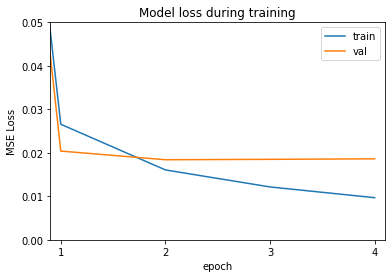

In [ ]:
# Lists of training and validation loss
validation_loss=[]
training_loss=[]

for epoch in training_stats:
  validation_loss.append(epoch['Valid. Loss'])
  training_loss.append(epoch['Training Loss'])

# Display Losses
plt.plot(training_loss)
plt.plot(validation_loss)
plt.title('Model loss during training')
plt.ylabel('MSE Loss')
plt.xlabel('epoch')
plt.xticks(ticks=[1,2,3,4])
plt.xlim((0.9,4.1))
plt.ylim((0,0.05))
plt.legend(['train', 'val'], loc='upper right')
plt.show()

The model seems to perform relatively well during training! Although there is a small amount of overfitting to the training data after the second epoch, the model still performs relatively well on the validation set, with a **best validation loss of 0.019 (MSE)** being achieved by the model after the second epoch. This translates to an **average error in score of 1.38 (RMSE)** when scaling the loss from 1-10. 

Lets do some more testing using our test dataset. First we need to run the model on the dataset:

In [ ]:
# ========================================
#               Testing
# ========================================

print("")
print("Running Testing...")

# Start time of testing
t0 = time.time()

model.eval()

total_test_loss = 0

# Testing dictionary, to group predictions based on their target values
testing_stats={'0.1':[],'0.2':[],'0.3':[],'0.4':[],'0.5':[],'0.6':[],'0.7':[],'0.8':[],'0.9':[],'1.0':[]}

# Loop through all test data
for step,batch in enumerate(test_dataloader):

    b_tokenized_reviews = batch[0].cuda()
    b_input_mask = batch[1].cuda()
    b_labels = batch[2].cuda()/10

    with torch.no_grad():
        preds=model(b_tokenized_reviews,b_input_mask).cuda()

    # Update testing dictionary with new batch of predictions
    for pred,label in zip(preds,b_labels):
      testing_stats[str(round(label.item(),1))].append(pred)

    loss = criterion(preds.squeeze(), b_labels)

    del b_tokenized_reviews,b_input_mask,b_labels

    total_test_loss += loss.item()
    
avg_test_loss = total_test_loss / len(test_dataloader)

print("  RMSE: {0:.2f}".format(avg_test_loss**0.5))

testing_time = format_time(time.time() - t0)

print("  Test Loss: {0:.2f}".format(avg_test_loss))
print("  Test took: {:}".format(testing_time))


Next, we evaluate the results:

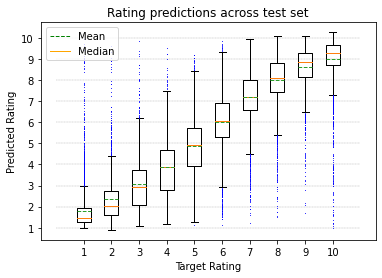

In [ ]:
# Remove ugly depreciation warnings
warnings.filterwarnings('ignore')

# Lists for scaled data, RMSE and size, with each element coming from a group of predictions from a given label
data=[]
rmse=[]
lengths=[]

# Loop through each label group
for rating in testing_stats:

  # Scale data
  data.append(torch.tensor(testing_stats[rating]).cpu()*10)
  # Get size of prediction set
  lengths.append(len(data[-1]))
  # Calculate prediction error for set
  error=torch.tensor(testing_stats[rating]).cpu()*10-float(rating)*10
  # MSE for set
  mse=np.power(error,2).mean()
  # RMSE for set
  rmse.append(np.power(mse,0.5).item())

# Plot bar graph
x=[1,2,3,4,5,6,7,8,9,10]
meanlineprops = dict(linestyle='--', linewidth=1)
flierprops = dict(marker='o', markerfacecolor='blue', markersize=1,markeredgecolor='none')
plt.yticks(ticks=x)
plt.hlines(x,0,11,linestyles='--',linewidth=0.3,color='grey')
plt.boxplot(data,meanline=True,showmeans=True,meanprops=meanlineprops,flierprops=flierprops)
plt.xlabel('Target Rating')
plt.ylabel('Predicted Rating')
plt.title('Rating predictions across test set')
legend_elements = [Line2D([0], [0], color='g',linestyle='--', lw=1, label='Median'),Line2D([0], [0], color='orange', lw=1, label='Mean')]
plt.legend(legend_elements,['Mean','Median','Outliers'])
plt.show()

The model performs almost identically in terms of MSE on the test and validation sets, as is expected when training for only 4 epochs. 

The figure above reveals the true performance of our model. Firstly, the prediction variance problem I discussed in my [EDA](https://github.com/shaikadish/imdbProject/blob/main/EDA_and_preprocessing.ipynb) for this project can clearly be seen in the long interquartile ranges and outliers for each target rating. Thankfully, there does not appear to be as much of a bias towards over-rating reviews as I expected, with the model being farely balanced in its over and under prediction of scores. 

Despite this variance, the model achieves **median values with an error less than 0.7 of the desired value for all target groups, mean values within an error less than 1 in all groups, and an average RMSE value bellow 1.4**.  In addition, there is a strong positive correlation between the predicted scores and the target scores across the ratings, indicating that despite the variance, the model is on average performing well in its predictions of review scores. 

I am happy with this result, given the problems with the dataset identified in the [EDA](https://github.com/shaikadish/imdbProject/blob/main/EDA_and_preprocessing.ipynb). The model is not performing perfectly, but it does seem to be able to predict review scores relatively well when given a review with enough discriptive information.

# Wrapping things up

That brings us to the end of this three part [tutorial](https://github.com/shaikadish/imdbProject). Whether you went through the whole thing, or just stole some code here and there, I hope you enjoyed it!

If you would like to play around with the model and see if it can predict the correct score for your own movie review, check out this [interactive demo!](https://colab.research.google.com/github/shaikadish/imdbProject/blob/main/rating_predictor_demo.ipynb)